In [14]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [3]:
maryland = ZipFile('md2020.pl.zip')
import csv
import codecs

with codecs.open('geolabels.csv',encoding='latin-1') as file:
    geolabels = list(csv.reader(file))[0]
with maryland.open('mdgeo2020.pl','r') as file:
    geo = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=geolabels, keep_default_na=False)
with codecs.open('pl1labels.csv',encoding='utf-8') as file:
    pl1labels = list(csv.reader(file))[0]
with maryland.open('md000012020.pl','r') as file:
    md1 = pd.read_csv(file,sep='|',index_col=False,encoding='utf-8',names=pl1labels, keep_default_na=False)
    
with codecs.open('pl2labels.csv',encoding='latin-1') as file:
    pl2labels = list(csv.reader(file))[0]    
with maryland.open('md000022020.pl','r') as file:
    md2 = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=pl2labels, keep_default_na=False)
    
with codecs.open('pl3labels.csv',encoding='latin-1') as file:
    pl3labels = list(csv.reader(file))[0]    
with maryland.open('md000032020.pl','r') as file:
    md3 = pd.read_csv(file,sep='|',index_col=False,encoding='latin-1',names=pl3labels, keep_default_na=False)    

c:\users\patri\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3,9,14,16,17,19,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,62,80,81,82,86,94,96) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
census_data = pd.concat([geo, md1, md2, md3],axis=1)

In [8]:
group_data = census_data[census_data['SUMLEV'] == 740]
nonnumeric_cols = 'COUNTY COUSUB PLACE AIANHH AITS AIHHTLI SDELM SDSEC SDUNI MEMI CSA METDIV CBSAPCI '
tract_class_cols = {c:{a:b for b,a in enumerate(set(group_data[c]))} for c in nonnumeric_cols.split()}
print('N=', len(group_data))
cols = 1
for c in tract_class_cols.values():
    print(len(c))
    cols += len(c)
print('D=', cols)
    
def row_length():
    idx = 0
    # Classifications
    for c,dc in tract_class_cols.items():
        idx += len(dc)
    # Geographic numerics
    idx += 4
    # Demographics
    # All
    idx += 8
    # Hispanic
    idx += 9
    # 18+
    idx += 9
    # Hispanic
    idx += 9 
    # Housing
    # Group quarters
    idx += 9
    return idx

def get_info(row):
    row_data = np.zeros( row_length())
    idx = 0
    # Classifications
    for c,dc in tract_class_cols.items():
#         print(idx, ': ', c)
        row_data[idx+dc[row[c]]] = 1
        idx += len(dc)
        
    # Geographic numerics
    block_area = row['AREALAND']+row['AREAWATR']
    row_data[idx] = row['AREALAND'] / block_area # % land
    block_pop = row['POP100'] 
    row_data[idx+1] = block_pop / block_area # pop density
    block_dens = block_pop / block_area
    row_data[idx+2] = row['HU100'] / max(1,row['POP100']) # housing density
    row_data[idx+3] = row['INTPTLAT']
    row_data[idx+4] = row['INTPTLON']
#     print(idx)
    idx += 4
    # Demographics
    # All
    block_pop = max(1,row['P0010001'])
    row_data[idx+1] = row['P0010003']  / block_pop # % white
    row_data[idx+2] = row['P0010004']  / block_pop # % black
    row_data[idx+3] = row['P0010005']  / block_pop # % indian/native
    row_data[idx+4] = row['P0010006']  / block_pop # % asian
    row_data[idx+5] = row['P0010007']  / block_pop # % island
    row_data[idx+6] = row['P0010008']  / block_pop # % other
    row_data[idx+7] = row['P0010010']  / block_pop # % two
    row_data[idx+8] = (row['P0010009']-row['P0010010'])  / block_pop # % >2
    idx += 8
#     print(idx)
    # Hispanic
    hisp_pop = row['P0020001']
    row_data[idx+1] = hisp_pop  / block_pop # % hispanic
    if hisp_pop == 0:
        hisp_pop = 1
    row_data[idx+2] = row['P0020005']  / hisp_pop # % white
    row_data[idx+3] = row['P0020006']  / hisp_pop # % black
    row_data[idx+4] = row['P0020007']  / hisp_pop # % indian/native
    row_data[idx+5] = row['P0020008']  / hisp_pop # % asian
    row_data[idx+6] = row['P0020009']  / hisp_pop # % island
    row_data[idx+7] = row['P0020010']  / hisp_pop # % other
    row_data[idx+8] = row['P0020012']  / hisp_pop # % two
    row_data[idx+9] = (row['P0020011']-row['P0020012'])  / hisp_pop # % >2
    idx += 9
#     print(idx)
    # 18+
    adult_pop = row['P0030001']
    row_data[idx+1] = adult_pop / block_pop # % adult
    if adult_pop == 0:
        adult_pop = 1
    row_data[idx+2] = row['P0030003']  / adult_pop # % white
    row_data[idx+3] = row['P0030004']  / adult_pop # % black
    row_data[idx+4] = row['P0030005']  / adult_pop # % indian/native
    row_data[idx+5] = row['P0030006']  / adult_pop # % asian
    row_data[idx+6] = row['P0030007']  / adult_pop # % island
    row_data[idx+7] = row['P0030008']  / adult_pop # % other
    row_data[idx+8] = row['P0030010']  / adult_pop # % two
    row_data[idx+9] = (row['P0030009']-row['P0030010'])  / adult_pop # % >2
    idx += 9
#     print(idx)
    # Hispanic
    hispadult_pop = row['P0040001']
    row_data[idx+1] = hispadult_pop  / block_pop # % hispanic
    if hispadult_pop == 0:
        hispadult_pop = 1
    row_data[idx+2] = row['P0040005']  / hispadult_pop # % white
    row_data[idx+3] = row['P0040006']  / hispadult_pop # % black
    row_data[idx+4] = row['P0040007']  / hispadult_pop # % indian/native
    row_data[idx+5] = row['P0040008']  / hispadult_pop # % asian
    row_data[idx+6] = row['P0040009']  / hispadult_pop # % island
    row_data[idx+7] = row['P0040010']  / hispadult_pop # % other
    row_data[idx+8] = row['P0040012']  / hispadult_pop # % two
    row_data[idx+9] = (row['P0040011']-row['P0040012'])  / hispadult_pop # % >2
    idx += 9 
    
    # Housing
    row_data[idx+1] = row['H0010002'] / max(1,row['H0010001'])
#     print(idx)
    # Group quarters
    row_data[idx+2] = row['P0050003']  / block_pop # % correctional
    row_data[idx+3] = row['P0050004']  / block_pop # % juvenile
    row_data[idx+4] = row['P0050005']  / block_pop # % nursing
    row_data[idx+5] = row['P0050006']  / block_pop # % other
    row_data[idx+6] = row['P0050008']  / block_pop # % college
    row_data[idx+7] = row['P0050009']  / block_pop # % military
    row_data[idx+8] = row['P0050010']  / block_pop # % other
#     print(idx+8)
    return row_data


def progress_bar(i,n,k):
    print('[%s%d%s] - %10d' % ( '|'*max(0, int(k*i/n)-1), int(10*((k*i)/n % 1)), '.'*(k - max(0, int(k*i/n)-1)), i), end='\r')

N= 9047
24
290
537
1
1
1
1
1
1
3
4
4
3
D= 872


In [9]:
numeric_cols = 'AREALAND AREAWATR POP100 HU100 INTPTLAT INTPTLON'
pop_cols1 = 'P0010001 P0010003 P0010004 P0010005 P0010006 P0010007 P0010008 P0010010 P0010009'
pop_cols2 = 'P0020001 P0020005 P0020006 P0020007 P0020008 P0020009 P0020010 P0020012 P0020011'
pop_cols3 =  'P0030001 P0030003 P0030004 P0030005 P0030006 P0030007 P0030008 P0030010 P0030009'
pop_cols4 =  'P0040001 P0040005 P0040006 P0040007 P0040008 P0040009 P0040010 P0040012 P0040011'

group_data = census_data[census_data['SUMLEV']==740]
rlen = row_length()
group_mat = np.zeros((group_data.shape[0], rlen))
for i, (rowid, row) in enumerate(group_data.iterrows()):
    progress_bar(i,len(group_data),50)
    group_mat[i] = get_info(row)
    

In [12]:
print(np.isnan(group_mat).sum())
print(np.isinf(group_mat).sum())
group_std = group_mat / np.std(group_mat, axis=0)
print(np.isnan(group_std).sum())
print(np.isinf(group_std).sum())
group_std[np.isnan(group_std)] = 0
group_std[np.isinf(group_std)] = 0

c:\users\patri\miniconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
c:\users\patri\miniconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


0
0
0
54282


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

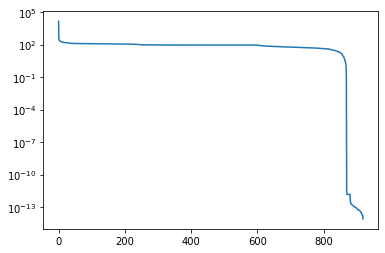

In [15]:
u,s,vt = np.linalg.svd(group_std, full_matrices=False)
plt.plot(s)
plt.yscale('log')
plt.show()

In [21]:
from numba import jit

In [36]:

def population_agglomerate(matrix, n, populations):
    pop_limit = sum(populations) / n
    clusters = {i: {'members': [i], 'pop':populations[i]} for i in range(len(matrix))}
    distances = {(i,j): np.square(clusters[i]['members'][0] - clusters[j]['members'][0]).sum() for i in range(len(matrix)) for j in range(i+1,len(matrix))}
    idx = len(clusters)
    while len(clusters) > n:
        print('{0: < 10}'.format(len(clusters)), end='\r')
        # Find the closest pair of clusters that don't exceed the pop_limit
        i,j = min(distances.items(), key=lambda x: x[1])[0]
        if clusters[i]['pop'] + clusters[j]['pop'] > pop_limit:
            break

        for c2 in clusters:
            if c2 == i or c2 == j:
                continue
            total_pop = max(1,clusters[i]['pop'] + clusters[j]['pop'] + clusters[c2]['pop'])
            if total_pop > pop_limit:
                distances[(c2,idx)] = np.inf
            else:
                distances[(c2,idx)] = (clusters[i]['pop'] + clusters[c2]['pop'])*distances[tuple(sorted([i,c2]))] / total_pop  +  (clusters[j]['pop'] + clusters[c2]['pop'])*distances[tuple(sorted([j,c2]))] / total_pop -  clusters[c2]['pop'] *distances[tuple(sorted([i,j]))] / total_pop
                if np.isnan(distances[(c2,idx)]):
                    print('Found NaN: ', distances[tuple(sorted([i,c2]))], distances[tuple(sorted([j,c2]))] , distances[tuple(sorted([i,j]))] )
        clusters[idx] = {'members': clusters[i]['members'] + clusters[j]['members'], 'pop': clusters[i]['pop'] + clusters[j]['pop']}   
        to_remove = []
        for k in distances:
            if i in k or j in k:
                to_remove.append(k)
        for k in to_remove:
            distances.pop(k)
        clusters.pop(i)
        clusters.pop(j)
        idx += 1
    return clusters

In [37]:
group_pops = np.array(group_data['POP100'].array)
clusts = population_agglomerate(group_std, 141, group_pops)

In [33]:
np.savez('maryland_matrix', matrix=group_std, pops=group_pops)

In [ ]:
def consolidate_clusters(matrix, clusters, n, populations):
    pop_limit = sum(populations) / n
    good_clusters = { key:clusters[key] for key in sorted(clusters, key=lambda x: -clusters[x]['pop'])[:n]}
    bad_clusters = { key:clusters[key] for key in sorted(clusters, key=lambda x: -clusters[x]['pop'])[n:]}
    while len(clusters) > n:
        for c in 
    

In [38]:
np.savez('maryland_clusters', clusters=clusts)

In [40]:
[(i,len(clusts[i]['members'])) for i in clusts]

[(17514, 20),
 (17518, 19),
 (17520, 20),
 (17531, 22),
 (17547, 22),
 (17569, 21),
 (17596, 20),
 (17609, 22),
 (17613, 23),
 (17620, 25),
 (17621, 26),
 (17623, 26),
 (17638, 25),
 (17642, 24),
 (17643, 26),
 (17651, 23),
 (17663, 29),
 (17664, 30),
 (17669, 25),
 (17673, 29),
 (17676, 28),
 (17680, 26),
 (17681, 23),
 (17683, 28),
 (17684, 28),
 (17686, 24),
 (17689, 29),
 (17690, 27),
 (17693, 27),
 (17697, 30),
 (17698, 30),
 (17699, 26),
 (17701, 28),
 (17704, 26),
 (17705, 30),
 (17708, 22),
 (17709, 28),
 (17710, 30),
 (17711, 30),
 (17712, 28),
 (17713, 29),
 (17714, 30),
 (17715, 29),
 (17716, 28),
 (17717, 32),
 (17718, 32),
 (17719, 28),
 (17720, 34),
 (17723, 31),
 (17724, 32),
 (17731, 29),
 (17735, 33),
 (17736, 32),
 (17741, 35),
 (17742, 25),
 (17744, 36),
 (17745, 35),
 (17747, 32),
 (17748, 33),
 (17755, 39),
 (17757, 34),
 (17759, 34),
 (17762, 38),
 (17763, 36),
 (17767, 37),
 (17770, 38),
 (17771, 34),
 (17773, 36),
 (17779, 33),
 (17780, 38),
 (17782, 37),
 (1778

In [43]:
[(i,clusts[i]['pop'], sum(group_pops)/141) for i in clusts]

[(17514, 26089, 43810.09929078014),
 (17518, 30291, 43810.09929078014),
 (17520, 27625, 43810.09929078014),
 (17531, 21878, 43810.09929078014),
 (17547, 28703, 43810.09929078014),
 (17569, 33974, 43810.09929078014),
 (17596, 26638, 43810.09929078014),
 (17609, 29768, 43810.09929078014),
 (17613, 26502, 43810.09929078014),
 (17620, 31631, 43810.09929078014),
 (17621, 25953, 43810.09929078014),
 (17623, 34816, 43810.09929078014),
 (17638, 32137, 43810.09929078014),
 (17642, 24982, 43810.09929078014),
 (17643, 38490, 43810.09929078014),
 (17651, 27339, 43810.09929078014),
 (17663, 29415, 43810.09929078014),
 (17664, 27348, 43810.09929078014),
 (17669, 35587, 43810.09929078014),
 (17673, 26640, 43810.09929078014),
 (17676, 25308, 43810.09929078014),
 (17680, 32047, 43810.09929078014),
 (17681, 35058, 43810.09929078014),
 (17683, 25686, 43810.09929078014),
 (17684, 23020, 43810.09929078014),
 (17686, 27438, 43810.09929078014),
 (17689, 36609, 43810.09929078014),
 (17690, 29579, 43810.099290

In [45]:
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg.fit(group_std[clusts[17913]['members']])

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [46]:
agg.children_.shape

(60, 2)

In [47]:
agg.children_[0]

array([30, 54], dtype=int64)

In [48]:
len(clusts[17913]['members'])

61

In [49]:
agg.children_[-1]

array([118, 119], dtype=int64)

In [51]:
class Tree:
    def __init__(self, members, population, vector, left=None, right=None, up=None):
        self.members = members
        self.population = population
        self.vector = vector
        self.left = left
        self.right = right
        self.up = up
    def merge(self, other):
        vector = (self.vector * self.population + other.vector * other.population) / (self.population + other.population)
        up = Tree(self.members + other.members, self.population + other.population, vector, left=self, right=other)
        self.up = up
        other.up = up
        return up


class WeightedAgglomerativeClustering:
    def __init__(self, n_clusters):
        self.n_clusters_ = n_clusters
        self.labels_ = None
        self.children_ = None
        self.population_ = None
        self.tree = None
    def fit(self, matrix, populations):
        pop_limit = sum(populations) / self.n_clusters_
        clusters = {i: Tree(members=[i], population=populations[i], vector=matrix[i]) for i in range(len(matrix))}
        distances = {(i,j): np.square(matrix[i] - matrix[j]).sum() for i in range(len(matrix)) for j in range(i+1,len(matrix))}
        idx = len(clusters)
        children = []
        
        while len(clusters) > self.n_clusters_:
            print('{0: < 10}'.format(len(clusters)), end='\r')
            # Find the closest pair of clusters that don't exceed the pop_limit
            i,j = min(distances.items(), key=lambda x: x[1])[0]
            if clusters[i].population + clusters[j].population > pop_limit:
                break
            joined = clusters[i].merge(clusters[j])
            for c2 in clusters:
                if c2 == i or c2 == j:
                    continue
                total_pop = clusters[i].population + clusters[j].population + clusters[c2].population
                if total_pop > pop_limit:
                    distances[(c2,idx)] = np.inf
                else:
                    distances[(c2,idx)] = (clusters[i].population + clusters[c2].population)*distances[tuple(sorted([i,c2]))] / total_pop  +  (clusters[j].population + clusters[c2].population)*distances[tuple(sorted([j,c2]))] / total_pop -  clusters[c2].population *distances[tuple(sorted([i,j]))] / total_pop
            clusters[idx] = joined   
            children.append((i,j,idx,joined.population))
            to_remove = []
            for k in distances:
                if i in k or j in k:
                    to_remove.append(k)
            for k in to_remove:
                distances.pop(k)
            clusters.pop(i)
            clusters.pop(j)
            idx += 1
        self.children_ = children
        self.population_ = populations
        if len(clusters) == 1:
            self.tree = list(clusters.values())[0]
        return clusters

In [ ]:
wag = WeightedAgglomerativeClustering(141)
wag.fit(group_std, group_pops)

In [53]:
{1}.union({2})

{1, 2}

In [56]:
group_data[group_data['POP100']==0]['P0010001']

51830    0
51836    0
51838    0
51839    0
51842    0
        ..
60862    0
60863    0
60864    0
60865    0
60866    0
Name: P0010001, Length: 1448, dtype: int64

In [55]:
group_data

,FILEID,STUSAB,SUMLEV,GEOVAR,GEOCOMP,CHARITER,CIFSN,LOGRECNO,GEOID,GEOCODE,...,P0050001,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010
51820,PLST,MD,740,0,0,0,0,51821,7400000US2400101-00090004472750001001,2400101-00090004472750001001,...,0,0,0,0,0,0,0,0,0,0
51821,PLST,MD,740,0,0,0,0,51822,7400000US2400101-00090004999990001001,2400101-00090004999990001001,...,0,0,0,0,0,0,0,0,0,0
51822,PLST,MD,740,0,0,0,0,51823,7400000US2400101-00090004999990001002,2400101-00090004999990001002,...,13,13,0,13,0,0,0,0,0,0
51823,PLST,MD,740,0,0,0,0,51824,7400000US2400102-00090096587750001003,2400102-00090096587750001003,...,0,0,0,0,0,0,0,0,0,0
51824,PLST,MD,740,0,0,0,0,51825,7400000US2400102-00090096999990001003,2400102-00090096999990001003,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60862,PLST,MD,740,0,0,0,0,60863,7400000US24510ZZZZZZ90000040002504013,24510ZZZZZZ90000040002504013,...,0,0,0,0,0,0,0,0,0,0
60863,PLST,MD,740,0,0,0,0,60864,7400000US24510ZZZZZZ90000040002505001,24510ZZZZZZ90000040002505001,...,0,0,0,0,0,0,0,0,0,0
60864,PLST,MD,740,0,0,0,0,60865,7400000US24510ZZZZZZ90000040002505002,24510ZZZZZZ90000040002505002,...,0,0,0,0,0,0,0,0,0,0
60865,PLST,MD,740,0,0,0,0,60866,7400000US24510ZZZZZZ90000040002506001,24510ZZZZZZ90000040002506001,...,0,0,0,0,0,0,0,0,0,0
